In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import date
from datetime import time
from datetime import datetime

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/test-data/Test_0qrQsBZ.csv
/kaggle/input/train-data/Train_SU63ISt.csv


In [2]:
# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "time_data.csv"):  
    csv = df.to_csv(index= False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [3]:
train_data = pd.read_csv("/kaggle/input/train-data/Train_SU63ISt.csv")
test_data = pd.read_csv("/kaggle/input/test-data/Test_0qrQsBZ.csv")

train_original=train_data.copy() 
test_original=test_data.copy()

In [4]:
train_data.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [5]:
train_data['Datetime'] = pd.to_datetime(train_data.Datetime,format='%d-%m-%Y %H:%M') 
test_data['Datetime'] = pd.to_datetime(test_data.Datetime,format='%d-%m-%Y %H:%M') 
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M') 
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

In [6]:
for i in (train_data, test_data, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [7]:
train_data['dayOfWeek']=train_data['Datetime'].dt.dayofweek 

In [8]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = train_data['Datetime'].apply(applyer) 
train_data['weekend']=temp2

Data Visualization

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


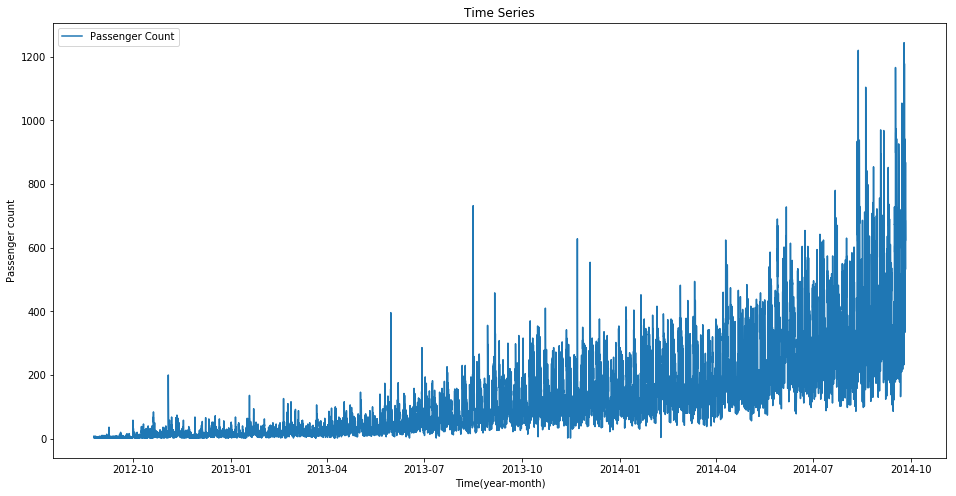

In [9]:
train_data.index = train_data['Datetime'] # indexing the Datetime to get the time period on the x-axis. 
df=train_data.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis. 
ts = df['Count'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')

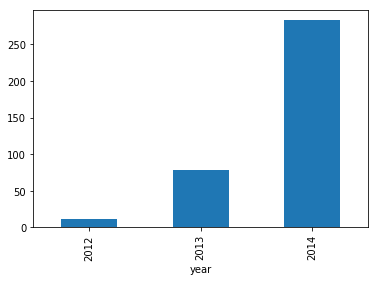

In [10]:
train_data.groupby("year")['Count'].mean().plot.bar()

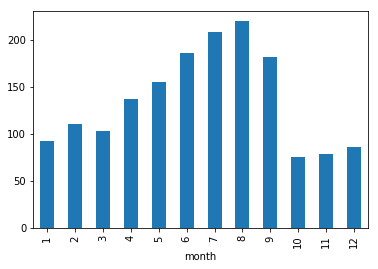

In [11]:
train_data.groupby("month")['Count'].mean().plot.bar()

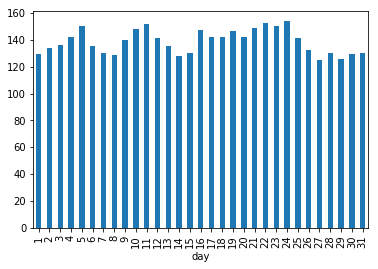

In [12]:
train_data.groupby("day")['Count'].mean().plot.bar()

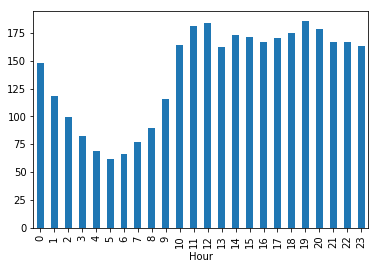

In [13]:
train_data.groupby("Hour")['Count'].mean().plot.bar()

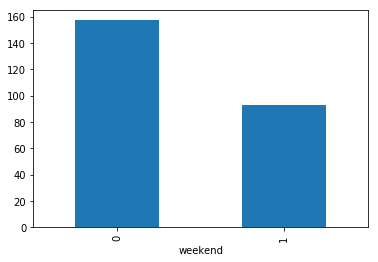

In [14]:
train_data.groupby("weekend")['Count'].mean().plot.bar()

**MODEL DEVELOPMENT**

Before the development we will split the data into training, testing and validation data sets. In time series splitting the data is not done randomly but a certain time period is taken for validation and training data sets. In this case I am taking last 3 months data as validation data set.

In [15]:
Train=train_data.loc['2012-08-25':'2014-06-24'] 
valid=train_data.loc['2014-06-25':'2014-09-25']

In [16]:
def submission(model):
    predict=model.forecast(len(test_data))
    submission = test_data[["ID"]]
    submission["Count"] = predict 
    return submission

Model 1 : Using Naive Approach

In [17]:
from sklearn.metrics import mean_squared_error

df = np.asarray(Train.Count)
y_pred = valid.copy()
y_pred['naive'] = df[len(df)-1]

rmse = np.sqrt(mean_squared_error(valid['Count'],y_pred['naive']))
print(rmse)

186.37368520699056


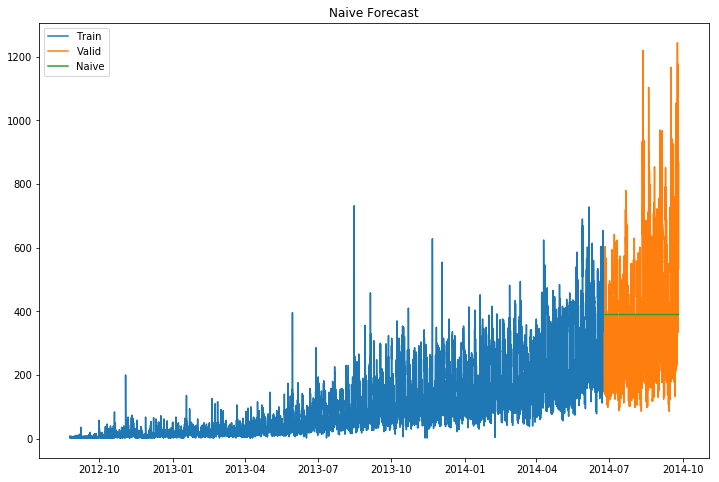

In [18]:
plt.figure(figsize=(12,8)) 
plt.plot(Train.index,Train['Count'],label = "Train")
plt.plot(valid.index,valid['Count'],label = "Valid")
plt.plot(y_pred.index,y_pred['naive'],label = "Naive")
plt.legend(loc='best') 
plt.title("Naive Forecast")
plt.show()

Model 2 : Moving Averages

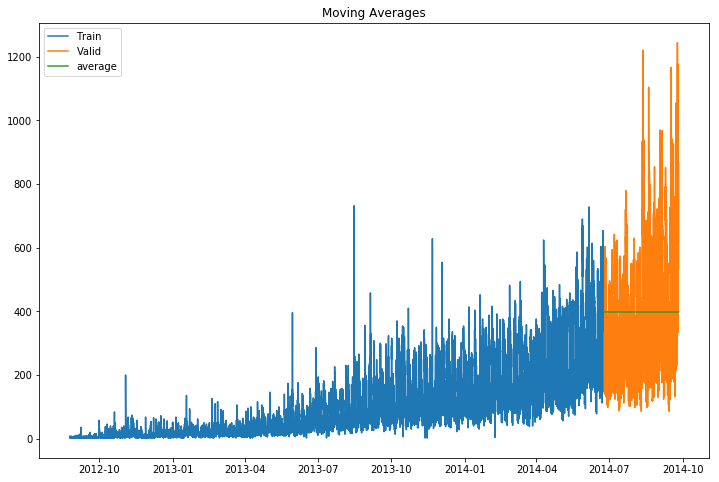

186.57550577403967


In [19]:
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(5).mean().iloc[-1]

plt.figure(figsize=(12,8)) 
plt.plot(Train.index,Train['Count'],label = "Train")
plt.plot(valid.index,valid['Count'],label = "Valid")
plt.plot(y_hat_avg.index,y_hat_avg['moving_avg_forecast'],label = "average")
plt.legend(loc='best') 
plt.title("Moving Averages")
plt.show()

rmse = np.sqrt(mean_squared_error(valid['Count'],y_hat_avg['moving_avg_forecast']))
print(rmse)

Model 3 : Simple Exponential Smoothing


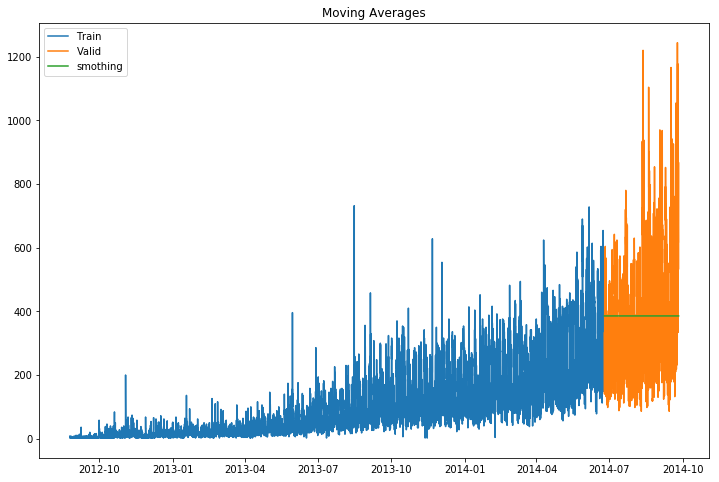

186.40944652452376


In [20]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

model = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False)

pred1 = valid.copy()
pred1["SES"] = model.forecast(len(valid))

plt.figure(figsize=(12,8)) 
plt.plot(Train.index,Train['Count'],label = "Train")
plt.plot(valid.index,valid['Count'],label = "Valid")
plt.plot(pred1.index,pred1["SES"],label = "smothing")
plt.legend(loc='best') 
plt.title("Moving Averages")
plt.show()

rmse = np.sqrt(mean_squared_error(valid['Count'],pred1['SES']))
print(rmse)

Holt’s Linear Trend Model

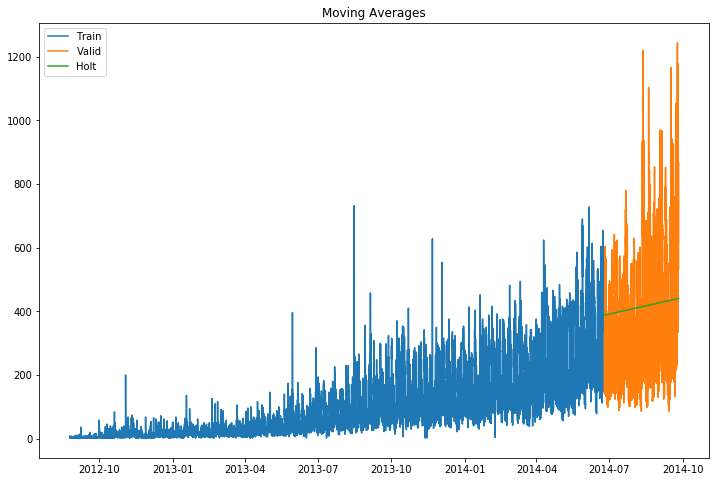

183.91710304565657


In [21]:
fit2 = Holt(np.asarray(Train['Count'])).fit()
y_holt = valid.copy()
y_holt["Holt"] = fit2.forecast(len(valid))

plt.figure(figsize=(12,8)) 
plt.plot(Train.index,Train['Count'],label = "Train")
plt.plot(valid.index,valid['Count'],label = "Valid")
plt.plot(y_holt.index,y_holt["Holt"],label = "Holt")
plt.legend(loc='best') 
plt.title("Moving Averages")
plt.show()

rmse = np.sqrt(mean_squared_error(valid['Count'],y_holt['Holt']))
print(rmse)

In [22]:
#Submission

df =submission(fit2)
predict=fit2.forecast(len(test_data))
test_data['prediction']=predict

create_download_link(df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Holt's Linear Trend on daily Time Series

In [23]:
train_original['ratio'] = train_original['Count']/train_original['Count'].sum() 

temp=train_original.groupby(['Hour'])['ratio'].sum()
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('GROUPby.csv') 

temp2=pd.read_csv("GROUPby.csv") 
temp2=temp2.drop('Hour.1',1) 

In [24]:
# Predicting by merging merge and temp2 
prediction=pd.merge(test_data, temp2, on='Hour', how='left') 

prediction['Count']=prediction['prediction']*prediction['ratio']*24 
submission=prediction.drop(['Datetime', 'year','month','day','prediction','Hour', 'ratio'],axis=1) 
create_download_link(submission)


Holt's Winter Trend

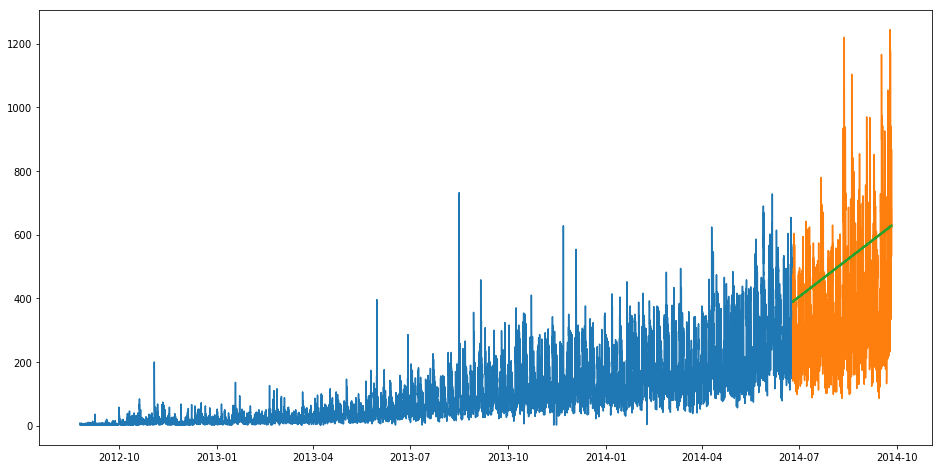

214.0212330275707


In [25]:
y_hat_avg = valid.copy() 
expSm = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit() 
y_hat_avg['Holt_Winter'] = expSm.forecast(len(valid)) 

plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'],label = 'Train')
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.show()

rms = np.sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter)) 
print(rms)